# Step 2b - Real-time semantic segmentation network
For  this  step,  you  have  to  train  a  real-time  segmentation  network 
(BiSeNet) on the Cityscapes dataset.  
-  Dataset: Cityscapes 
-  Training epochs: 50 
-  Training resolution (Cityscapes): 1024x512 
-  Test resolution (Cityscapes): 1024x512 
-  Backbone: ResNet18 (pre-trained on ImageNet)
-  Semantic classes: 19 
-  Metrics: mIoU, latency, FLOPs, number of parameters.

## Tuning learning rate

### Tuning Luci (sevuoi aggiungere commenti e/o risultati)

### Learning rate  $ =0.00625$
With a *batch size of 4, it is fair to re-evaluate the **learning rate* from that presented in the papers, as a smaller batch size implies:

* noisier gradient estimates
* higher probability of instability
* but also higher implicit regularisation

Many papers, including that of [Goyal et al., 2017](https://arxiv.org/abs/1706.02677), suggest that the learning rate can *scalar linearly with batch size*:

$$
\text{LR}{\text{new}} = \text{LR}{\text{base}} \times \frac{\text{BS}{\text{new}}}{\text{BS}{\text{base}}}
$$

In our case:

$$
\text{LR} = 0.025 \times \frac{4}{16} = 0.00625
$$

So the recommended *learning rate with batch size 4:*

$$
\text{lr} = 0.00625
$$

with:

* *SGD*
* *momentum = 0.9*
* *weight decay = 1e-4*
* *poly scheduler with power = 0.9*

## Tuning loss function
Four different types of loss have been studied:

✅ 1. *Dice Loss*

*Overlap improvement (IoU-like)*.
* Formula:

  $$
  \text{Dice} = 1 - \frac{2 \cdot |P \cap G|}{|P| + |G|}
  $$
* It is differentiable and often combined with CrossEntropy.
* Ideal for *small objects* and *precise contours*.

✅ 2. *Lovász-Softmax Loss*

* Optimises *mIoU* directly, unlike EC.
* Widely used in competitions (e.g. on Kaggle).
* Requires softmax on logits before calculation.

✅ 3. *Tversky loss*

* General of dice. Allows balancing FP and FN:

  $$
  Tversky(P, G) = \frac{|P \cap G|}{|P \cap G| + \alpha |P - G| + \beta |G - P|}
  $$

  Where: $alpha$ penalises FPs, $beta$ FNs.
* Useful if you are more interested in certain types of errors.

✅ 4. *Cross Entropy loss*

* Measures the **difference between predicted class probabilities and true labels**.
* Formula (pixel classification):

  $$
  \text{CE}(p, y) = -\sum_{c=1}^{C} y_c \log(p_c)
  $$

  where:

  * $C$ = number of classes,
  * $y_c$ = 1 if the pixel belongs to class $c$, 0 otherwise,
  * $p_c$ = predicted probability for class $c$.
* Favours **corrected classifications pixel by pixel**.
* Is the standard loss for **multi-class problems**.
* Very stable and easy to optimise.
* Limitation: **does not directly optimise mIoU** (metric-based loss).

The approach was therefore to run using these settings:
- $lr=0.00625$
- utilizing a quarter of the training and validation dataset for faster tuning
- optimizing one loss function at a time

### Analysis of Loss Function Performance and Combination Strategy

The following code cell displays the results from the experimental runs using different individual loss functions. Comparing these outcomes helps us determine the best strategy for combining them to achieve even better results.

Here is a summary of the performance (likely measured by mIoU based on context):

  * **CrossEntropy**: **\~38.89%** ✅ - Best individual performance
  * **Tversky**: **\~34.90%** 🔸 - Outperformed Lovász
  * **Lovász-Softmax**: **\~33.39%** - Lowest performance in these runs

**Empirical Analysis from Individual Runs:**

Based on the results observed:

  * **CrossEntropy ($\\mathcal{L}\_{CE}$)**: Demonstrated the most stable and highest performance. It serves as a robust baseline.
  * **Tversky Loss ($\\mathcal{L}\_{Tversky}$)**: Showed a strong performance progression and reached a high mIoU. It's particularly useful in contexts with class imbalance, helping to improve the segmentation of smaller classes.
  * **Lovász-Softmax ($\\mathcal{L}\_{Lovász}$)**: While theoretically interesting for directly optimizing the IoU metric, its performance in these specific runs was the lowest observed.
  * **Dice Loss ($\\mathcal{L}\_{Dice}$)**: (Although not listed in the top 3, analysis often considers it) Typically useful for handling class imbalance, but can sometimes show more fluctuations or slightly lower performance compared to top contenders like Tversky in certain scenarios.

-----

**Strategies for Combining Losses**

These four combinations represent different strategies for leveraging the strengths of individual loss functions (CrossEntropy, Lovász-Softmax, Tversky, Dice) to optimize performance, particularly the mean Intersection over Union (mIoU). The weighting assigned to each loss reflects its perceived importance or intended role in the overall optimization process based on the experimental results.

The general form of the composite loss is:
$$\mathcal{L}_{\text{total}} = \alpha \cdot \mathcal{L}_{\text{CE}} + \beta \cdot \mathcal{L}_{\text{Lovász}} + \gamma \cdot \mathcal{L}_{\text{Tversky}} + \theta \cdot \mathcal{L}_{\text{Dice}}$$
where the weights $\\alpha, \\beta, \\gamma, \\theta$ sum to 1.

Let's look at each specific combination:

1.  **Combination 1: CrossEntropy + Lovász-Softmax**

      * **Losses Included:** CrossEntropy ($\\mathcal{L}*{\\text{CE}}$), Lovász-Softmax ($\\mathcal{L}*{\\text{Lovász}}$)
      * **Weights:**
        ```
        alpha = 0.7  # CrossEntropy
        beta = 0.3   # Lovász-Softmax
        # gamma = 0.0, theta = 0.0
        ```
      * **Rationale:** This combination pairs the most stable and individually highest-performing loss (CrossEntropy) with the loss designed to directly optimize the IoU metric (Lovász-Softmax). The higher weight given to CrossEntropy ($\\alpha = 0.7$) indicates that it serves as the primary driver for stable overall convergence. The smaller weight for Lovász-Softmax ($\\beta = 0.3$) suggests an attempt to incorporate its potential for direct IoU improvement, despite its observed lower individual performance or stability compared to CE.

2.  **Combination 2: CrossEntropy + Tversky**

      * **Losses Included:** CrossEntropy ($\\mathcal{L}*{\\text{CE}}$), Tversky ($\\mathcal{L}*{\\text{Tversky}}$)
      * **Weights:**
        ```
        alpha = 0.7  # CrossEntropy
        gamma = 0.3  # Tversky
        # beta = 0.0, theta = 0.0
        ```
      * **Rationale:** This is similar in structure to Combination 1, but replaces Lovász with Tversky. It combines the stable, high-performing CrossEntropy with Tversky, which also showed strong performance progression and is known for handling class imbalance. The weights again prioritize CrossEntropy ($\\alpha = 0.7$) for stability. Tversky gets a significant weight ($\\gamma = 0.3$) to contribute its robustness to imbalance and its good overall performance observed in the individual runs. This combination was identified as potentially the "best 2-component combination" due to Tversky's strong showing.

3.  **Combination 3: CrossEntropy + Tversky + Lovász**

      * **Losses Included:** CrossEntropy ($\\mathcal{L}*{\\text{CE}}$), Lovász-Softmax ($\\mathcal{L}*{\\text{Lovász}}$), Tversky ($\\mathcal{L}\_{\\text{Tversky}}$)
      * **Weights:**
        ```
        alpha = 0.6  # CrossEntropy
        beta = 0.2   # Lovász-Softmax
        gamma = 0.2  # Tversky
        # theta = 0.0
        ```
      * **Rationale:** This combination attempts to leverage the benefits of the top two performers (CE, Tversky) and the IoU-optimizing loss (Lovász) simultaneously. CrossEntropy retains the highest weight ($\\alpha = 0.6$) as the core stable component. Tversky and Lovász receive equal, smaller weights ($\\beta = 0.2, \\gamma = 0.2$), suggesting an effort to gain both imbalance handling (Tversky) and direct IoU signal (Lovász) without letting either dominant or potentially destabilize the training, especially given Lovász's lower individual performance. This approach increases complexity and risk of instability compared to 2-component combinations.

4.  **Combination 4: CrossEntropy + Lovász + Tversky + Dice (Recommended)**

      * **Losses Included:** CrossEntropy ($\\mathcal{L}*{\\text{CE}}$), Lovász-Softmax ($\\mathcal{L}*{\\text{Lovász}}$), Tversky ($\\mathcal{L}*{\\text{Tversky}}$), Dice ($\\mathcal{L}*{\\text{Dice}}$)
      * **Weights:**
        ```
        alpha = 0.4  # CrossEntropy
        beta = 0.1   # Lovász
        gamma = 0.4  # Tversky
        theta = 0.1  # Dice
        ```
      * **Rationale:** This is the comprehensive 4-component combination incorporating all evaluated losses. The weights are strategically distributed based on the empirical analysis. CrossEntropy ($\\alpha = 0.4$) and Tversky ($\\gamma = 0.4$) receive the highest and equal weights, reflecting their observed strong performance and complementary benefits (stability/baseline from CE, imbalance handling/accuracy from Tversky). Lovász ($\\beta = 0.1$) and Dice ($\\theta = 0.1$) receive smaller weights. This indicates they are included for fine-tuning purposes – Lovász to potentially nudge the optimization directly towards IoU, and Dice to provide additional robustness against class imbalance, without their less stable individual behaviors significantly impacting the overall training convergence. This is presented as the recommended combination due to this balanced approach leveraging multiple strengths.

-----

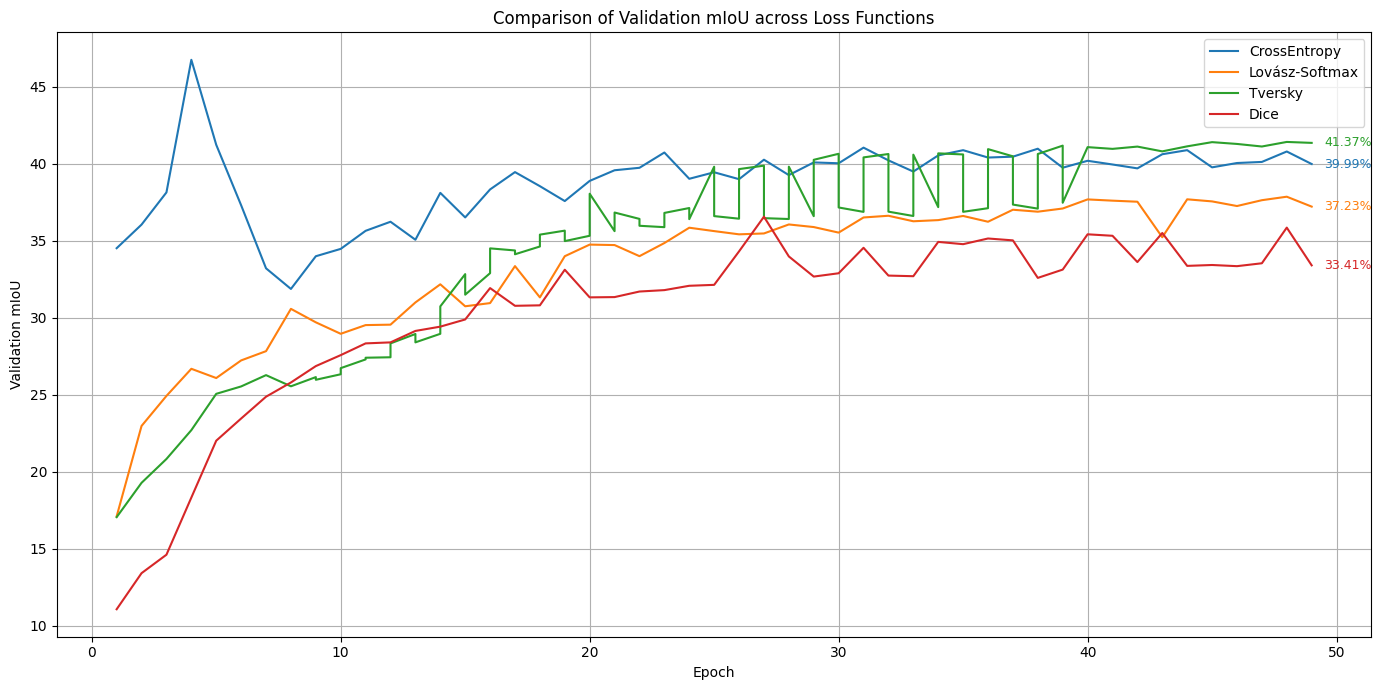

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV files exported from Weights & Biases
df_ce = pd.read_csv("wandb_export_2025-05-13T20_57_06.466+02_00.csv") # CrossEntropy
df_lovasz = pd.read_csv("wandb_export_2025-05-13T20_56_59.133+02_00.csv") # Lovász-Softmax
df_tversky = pd.read_csv("wandb_export_2025-05-13T21_27_20.104+02_00.csv") # Tversky
df_dice = pd.read_csv("wandb_export_2025-05-13T21_29_15.717+02_00.csv") # Dice

# Extract val_mIoU and epoch from each file and ensure they are sorted by epoch
# Sorting is important to correctly get the last value
ce_miou = df_ce[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
lovasz_miou = df_lovasz[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
tversky_miou = df_tversky[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
dice_miou = df_dice[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')

# --- Calculate final values ---
# Get the last row of each dataframe to obtain the final epoch and final mIoU
last_ce = ce_miou.iloc[-1]
last_lovasz = lovasz_miou.iloc[-1]
last_tversky = tversky_miou.iloc[-1]
last_dice = dice_miou.iloc[-1]

# --- Plot ---
# Increase the figure size
plt.figure(figsize=(14, 7)) # Changed from (12, 6) to (14, 7)

# Plot the lines and save references to get the colors
line_ce, = plt.plot(ce_miou['epoch'], ce_miou['val_mIoU'], label='CrossEntropy')
line_lovasz, = plt.plot(lovasz_miou['epoch'], lovasz_miou['val_mIoU'], label='Lovász-Softmax')
line_tversky, = plt.plot(tversky_miou['epoch'], tversky_miou['val_mIoU'], label='Tversky')
line_dice, = plt.plot(dice_miou['epoch'], dice_miou['val_mIoU'], label='Dice')

# --- Add text with final values ---
# Define a small offset to position the text slightly to the right of the last point
text_offset_x = 0.5 # You can adjust further if needed

# Add text for each loss
plt.text(last_ce['epoch'] + text_offset_x, last_ce['val_mIoU'], f"{last_ce['val_mIoU']:.2f}%",
         color=line_ce.get_color(), ha='left', va='center', fontsize=9)
plt.text(last_lovasz['epoch'] + text_offset_x, last_lovasz['val_mIoU'], f"{last_lovasz['val_mIoU']:.2f}%",
         color=line_lovasz.get_color(), ha='left', va='center', fontsize=9)
plt.text(last_tversky['epoch'] + text_offset_x, last_tversky['val_mIoU'], f"{last_tversky['val_mIoU']:.2f}%",
         color=line_tversky.get_color(), ha='left', va='center', fontsize=9)
plt.text(last_dice['epoch'] + text_offset_x, last_dice['val_mIoU'], f"{last_dice['val_mIoU']:.2f}%",
         color=line_dice.get_color(), ha='left', va='center', fontsize=9)


plt.xlabel('Epoch')
plt.ylabel('Validation mIoU')
plt.title('Comparison of Validation mIoU across Loss Functions')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust the layout to prevent text/labels from overlapping
plt.show()

We then proceeded to analyse the 4 options given above, the results of which are now shown in terms of epochs wrt mIoU values.

Analysing the graph showing the development of the Validation mIoU for the different loss combinations over the epochs, we can make the following brief comments:

1.  **The Best Combinations:** The combinations **‘Tversky + CE’ (red line)** and **‘CE + Lovász + Tversky’ (green line)** show the best final performance, reaching the highest mIoU values (around 44.05% and 43.93% respectively) towards the end of the training. The combination ‘Tversky + CE’ seems to be slightly ahead in the final plateau.

2.  **The Combination with All Losses:** The combination **‘All Losses (CE+L+T+D)’ (orange line)** performs very close to the best, ranking just below (about 43.85% final). This suggests that the inclusion of all losses can be effective.

3.  **The combination **‘CE + Lovász (0.7/0.3)’ (blue line)** shows the lowest overall performance of the four tested in these runs, finishing with the lowest mIoU value (about 43.03%).

4.  **General trend:** All combinations show a clear improvement in mIoU over the epochs, with a faster growth phase initially and a slowdown (plateau) in the final epochs, suggesting a trend towards convergence. Fluctuations in the validation metrics are visible, which is normal.

In summary, based on this graph, combinations including **Tversky and CrossEntropy (both alone and with the addition of Lovász)** seem to be the most promising in terms of final validation performance for this experimental setup.

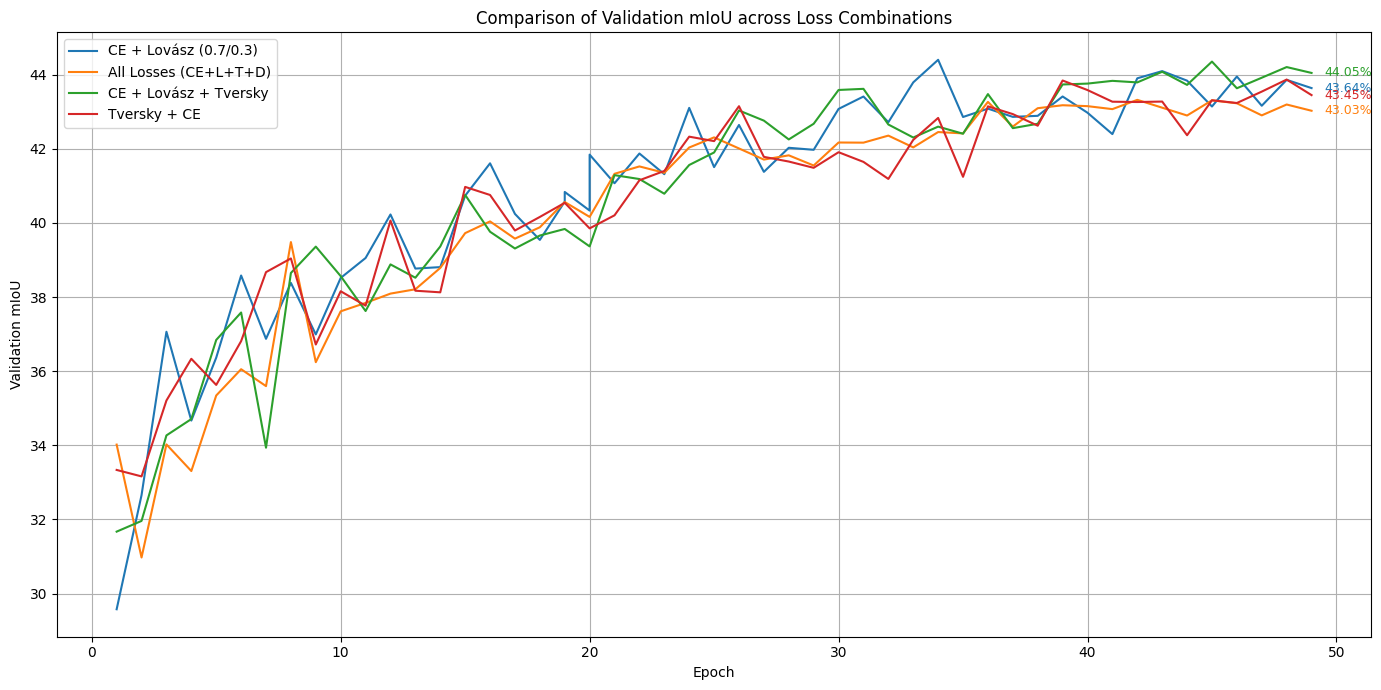

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV files exported from Weights & Biases with clearer variable names
df_ce_lovasz = pd.read_csv("BiSeNet_lr_0.00625_0.7ce_0.3ls.csv") # CE + Lovász (0.7/0.3)
df_all = pd.read_csv("BiSeNet_lr_0.00625_all.csv")         # All Losses (CE+L+T+D)
df_ce_lovasz_tversky = pd.read_csv("BiSeNet_lr_0.00625_cr_lv_tv.csv") # CE + Lovász + Tversky
df_tversky_ce = pd.read_csv("BiSeNet_lr_0.00625_Tversky_CrossEntropy.csv") # Tversky + CE

# Extract val_mIoU and epoch from each file and ensure they are sorted by epoch
ce_lovasz_miou = df_ce_lovasz[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
all_miou = df_all[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
ce_lovasz_tversky_miou = df_ce_lovasz_tversky[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')
tversky_ce_miou = df_tversky_ce[['epoch', 'val_mIoU']].dropna().sort_values(by='epoch')


# --- Calculate final values ---
# Get the last row of each dataframe to obtain the final epoch and final mIoU
last_ce_lovasz = ce_lovasz_miou.iloc[-1]
last_all = all_miou.iloc[-1]
last_ce_lovasz_tversky = ce_lovasz_tversky_miou.iloc[-1]
last_tversky_ce = tversky_ce_miou.iloc[-1]

# --- Plot ---
# Increase the figure size (already done in the previous step, keeping it)
plt.figure(figsize=(14, 7))

# Plot the lines with the new consistent labels and save references to get the colors
line_ce_lovasz, = plt.plot(ce_lovasz_miou['epoch'], ce_lovasz_miou['val_mIoU'], label='CE + Lovász (0.7/0.3)')
line_all, = plt.plot(all_miou['epoch'], all_miou['val_mIoU'], label='All Losses (CE+L+T+D)')
line_ce_lovasz_tversky, = plt.plot(ce_lovasz_tversky_miou['epoch'], ce_lovasz_tversky_miou['val_mIoU'], label='CE + Lovász + Tversky')
line_tversky_ce, = plt.plot(tversky_ce_miou['epoch'], tversky_ce_miou['val_mIoU'], label='Tversky + CE')


# --- Add text with final values and the new labels ---
# Define a small offset to position the text slightly to the right of the last point
text_offset_x = 0.5 # You can adjust further if needed

# Add text for each combination
plt.text(last_ce_lovasz['epoch'] + text_offset_x, last_ce_lovasz['val_mIoU'], f"{last_ce_lovasz['val_mIoU']:.2f}%",
         color=line_ce_lovasz.get_color(), ha='left', va='center', fontsize=9)
plt.text(last_all['epoch'] + text_offset_x, last_all['val_mIoU'], f"{last_all['val_mIoU']:.2f}%",
         color=line_all.get_color(), ha='left', va='center', fontsize=9)
plt.text(last_ce_lovasz_tversky['epoch'] + text_offset_x, last_ce_lovasz_tversky['val_mIoU'], f"{last_ce_lovasz_tversky['val_mIoU']:.2f}%",
         color=line_ce_lovasz_tversky.get_color(), ha='left', va='center', fontsize=9)
plt.text(last_tversky_ce['epoch'] + text_offset_x, last_tversky_ce['val_mIoU'], f"{last_tversky_ce['val_mIoU']:.2f}%",
         color=line_tversky_ce.get_color(), ha='left', va='center', fontsize=9)


plt.xlabel('Epoch')
plt.ylabel('Validation mIoU')
plt.title('Comparison of Validation mIoU across Loss Combinations') # Updated the title
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust the layout to prevent text/labels from overlapping
plt.show()

The scatter plot in the next cell visualizes the trade-off between the total training time (X-axis) and the final validation mIoU (Y-axis) for the four different loss function combinations.

* Points further to the **top-left** represent a better trade-off (higher performance for less time).
* The **"Tversky + CE"** combination is the fastest (~119 min) but achieves a moderate mIoU (~43.45%).
* The **"CE + Lovász + Tversky"** combination is the most computationally expensive (~174 min) but delivers the highest final mIoU (~44.05%).
* The **"All Losses"** combination is also quite slow (~170 min) but resulted in the lowest mIoU among the four (~43.03%), indicating a less favorable trade-off in these specific runs.
* The **"CE + Lovász (0.7/0.3)"** combination falls in the middle for both time (~139 min) and mIoU (~43.64%), offering an intermediate balance.

In summary, the plot clearly shows the expected trade-off: achieving higher mIoU generally requires more training time. "Tversky + CE" is the most efficient in terms of time, while "CE + Lovász + Tversky" offers the peak performance at the cost of being the slowest. The "All Losses" combination appears to be the least effective trade-off in this comparison.

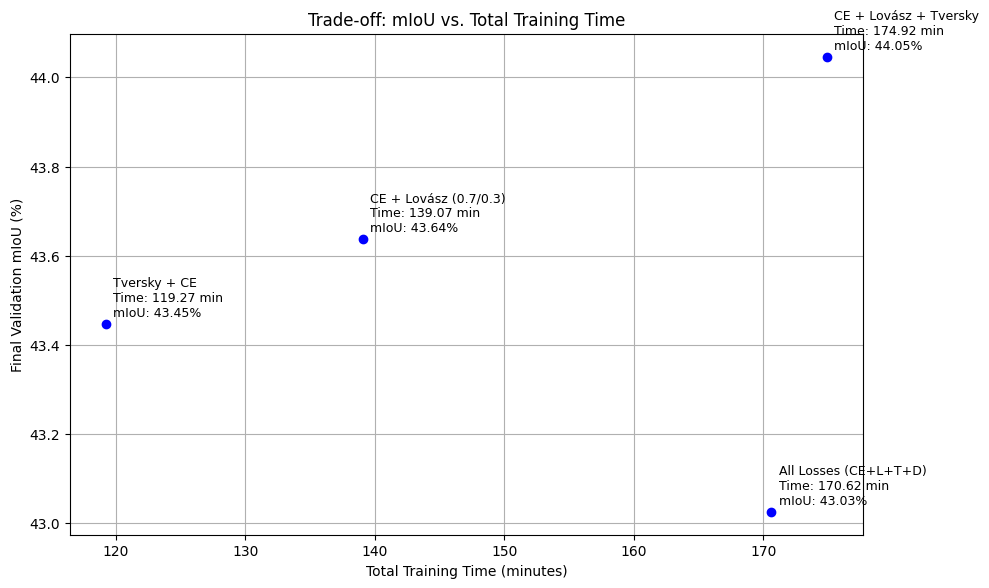

In [15]:
results = []

def process_df(df, label):
    # Drop rows with missing key data and sort by epoch to get latest values reliably
    df_clean = df.dropna(subset=['epoch', 'val_mIoU', 'Runtime']).sort_values(by='epoch')
    if not df_clean.empty:
        # Calculate total runtime by summing the 'Runtime' column (assuming it's per epoch or step)
        total_runtime_sec = df_clean['Runtime'].sum()  # Total time in seconds
        total_runtime_min = total_runtime_sec / 60     # Converted to minutes
        final_miou = df_clean.iloc[-1]['val_mIoU']     # Final mIoU (from the last epoch)
        results.append({'label': label, 'miou': final_miou, 'runtime': total_runtime_min})

# Apply the processing function to each dataframe
process_df(df_ce_lovasz, 'CE + Lovász (0.7/0.3)')
process_df(df_all, 'All Losses (CE+L+T+D)')
process_df(df_ce_lovasz_tversky, 'CE + Lovász + Tversky')
process_df(df_tversky_ce, 'Tversky + CE')

# Extract data into lists for plotting
runtimes = [r['runtime'] for r in results]
mious = [r['miou'] for r in results]
labels = [r['label'] for r in results]

# --- Create the scatter plot ---
plt.figure(figsize=(10, 6))
plt.scatter(runtimes, mious, color='blue') # Using a single color for all points

# Define offsets for text placement relative to points
offset_x = (max(runtimes) - min(runtimes)) * 0.01 if len(runtimes) > 1 else 0.5 # Handle case with single point
offset_y = (max(mious) - min(mious)) * 0.01 if len(mious) > 1 else 0.05 # Handle case with single point


# Add labels to each point
for i, label in enumerate(labels):
    plt.text(runtimes[i] + offset_x, mious[i] + offset_y,
             f"{label}\nTime: {runtimes[i]:.2f} min\nmIoU: {mious[i]:.2f}%", # Formatted label including time and mIoU
             fontsize=9, ha='left', va='bottom')

# Set plot labels and title
plt.xlabel('Total Training Time (minutes)') # Ensure the time unit is correct based on 'Runtime' column
plt.ylabel('Final Validation mIoU (%)')
plt.title('Trade-off: mIoU vs. Total Training Time')
plt.grid(True) # Add grid for readability

# Adjust layout and display plot
plt.tight_layout()
plt.show()

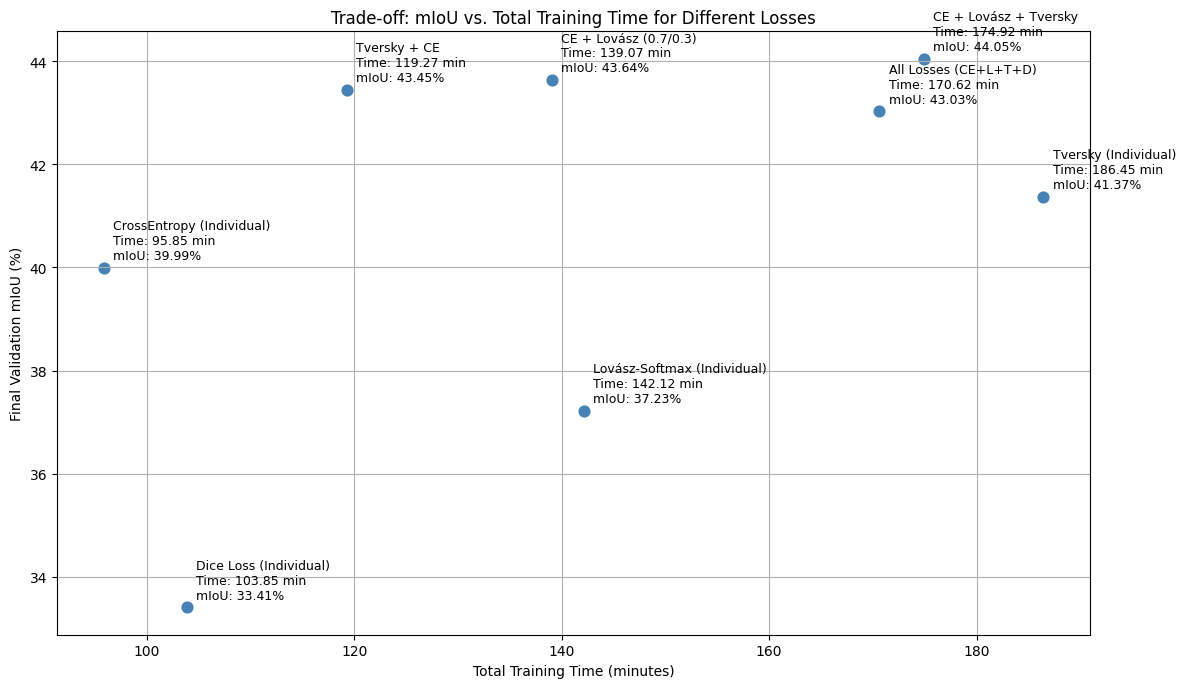

In [5]:
# Load the datasets for individual losses
df_ce = pd.read_csv("wandb_export_2025-05-13T20_57_06.466+02_00.csv") # CrossEntropy
df_lovasz = pd.read_csv("wandb_export_2025-05-13T20_56_59.133+02_00.csv") # Lovász
df_tversky = pd.read_csv("wandb_export_2025-05-13T21_27_20.104+02_00.csv") # Tversky
df_dice = pd.read_csv("wandb_export_2025-05-13T21_29_15.717+02_00.csv") # Dice

# Load the datasets for loss combinations
df_ce_lovasz = pd.read_csv("BiSeNet_lr_0.00625_0.7ce_0.3ls.csv") # CE + Lovász (0.7/0.3)
df_all = pd.read_csv("BiSeNet_lr_0.00625_all.csv")         # All Losses (CE+L+T+D)
df_ce_lovasz_tversky = pd.read_csv("BiSeNet_lr_0.00625_cr_lv_tv.csv") # CE + Lovász + Tversky
df_tversky_ce = pd.read_csv("BiSeNet_lr_0.00625_Tversky_CrossEntropy.csv") # Tversky + CE


# List to collect the results
results = []

def process_df(df, label):
    # Drop rows with missing key data and sort by epoch to get latest values reliably
    # Assumes 'Runtime' column exists and is cumulative or per-step/epoch runtime
    df_clean = df.dropna(subset=['epoch', 'val_mIoU', 'Runtime']).sort_values(by='epoch')
    if not df_clean.empty:
        # Calculate total runtime by summing the 'Runtime' column
        total_runtime_sec = df_clean['Runtime'].sum() # Total time in seconds (assuming sum is appropriate)
        total_runtime_min = total_runtime_sec / 60     # Converted to minutes
        final_miou = df_clean.iloc[-1]['val_mIoU']     # Final mIoU (from the last epoch)
        results.append({'label': label, 'miou': final_miou, 'runtime': total_runtime_min})

# Process data for multiple combinations
process_df(df_ce_lovasz, 'CE + Lovász (0.7/0.3)')
process_df(df_all, 'All Losses (CE+L+T+D)')
process_df(df_ce_lovasz_tversky, 'CE + Lovász + Tversky')
process_df(df_tversky_ce, 'Tversky + CE')

# Process data for individual losses
process_df(df_ce, 'CrossEntropy (Individual)') # Added '(Individual)' for clarity
process_df(df_lovasz, 'Lovász-Softmax (Individual)') # Added '(Individual)' for clarity
process_df(df_tversky, 'Tversky (Individual)') # Added '(Individual)' for clarity
process_df(df_dice, 'Dice Loss (Individual)') # Added '(Individual)' for clarity

# Data extraction for plotting
runtimes = [r['runtime'] for r in results]
mious = [r['miou'] for r in results]
labels = [r['label'] for r in results]

# --- Single Plot ---
plt.figure(figsize=(12, 7))
plt.scatter(runtimes, mious, color='steelblue', s=60) # s controls marker size

# Define offsets for text placement relative to points
offset_x = (max(runtimes) - min(runtimes)) * 0.01 if len(runtimes) > 1 else 0.5 # Handle case with single point
offset_y = (max(mious) - min(mious)) * 0.01 if len(mious) > 1 else 0.05 # Handle case with single point

# Add labels to each point
for i, label in enumerate(labels):
    plt.text(runtimes[i] + offset_x, mious[i] + offset_y,
             f"{label}\nTime: {runtimes[i]:.2f} min\nmIoU: {mious[i]:.2f}%", # Formatted label including time and mIoU
             fontsize=9, ha='left', va='bottom')

# Set plot labels and title
plt.xlabel('Total Training Time (minutes)') # Ensure the time unit is correct
plt.ylabel('Final Validation mIoU (%)')
plt.title('Trade-off: mIoU vs. Total Training Time for Different Losses')
plt.grid(True) # Add grid for readability

# Adjust layout and display plot
plt.tight_layout()
plt.show()